<a href="https://colab.research.google.com/github/jgtres/GrupalAct2_RNC/blob/main/Actividad_2_HJZ_2901.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACTIVIDAD 2: REDES NEURONALES CONVOLUCIONALES

---

En esta actividad, vamos a trabajar con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. En particular, vamos a clasificar imágenes de personajes de la conocida serie de los Simpsons.

Como las CNN profundas son un tipo de modelo bastante avanzado y computacionalmente costoso, se recomienda hacer la práctica en Google Colaboratory con soporte para GPUs. En [este enlace](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) se explica cómo activar un entorno con GPUs. *Nota: para leer las imágenes y estandarizarlas al mismo tamaño se usa la librería opencv. Esta ĺibrería está ya instalada en el entorno de Colab, pero si trabajáis de manera local tendréis que instalarla.*

<center><img src="https://i.imgur.com/i8zIGqX.jpg" style="text-align: center" height="300px"></center>

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie. Este dataset ha sido recopilado por [Alexandre Attia](http://www.alexattia.fr/) y es más complejo que el dataset de Fashion MNIST que hemos utilizado hasta ahora. Aparte de tener más clases (vamos a utilizar los 18 personajes con más imágenes), los personajes pueden aparecer en distintas poses, en distintas posiciones de la imagen o con otros personajes en pantalla (si bien el personaje a clasificar siempre aparece en la posición predominante).

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)

Antes de empezar la práctica, se recomienda descargar las imágenes y echarlas un vistazo.


# Integrantes

Hector Alejandro Aguirre Garza  
Jonathan Guevara Soto  
Luis Zendel Samperio Guzmán  


# Descripción del Dataset

El dataset contiene imágenes de personajes de la serie Los Simpsons organizadas para tareas de clasificación. Este dataset fue diseñado para entrenar modelos de aprendizaje profundo (Deep Learning), específicamente redes neuronales convolucionales (CNN), con el objetivo de identificar correctamente a los personajes en imágenes.

##Estructura del Dataset
* Conjunto de entrenamiento:

  * Contiene imágenes de cada personaje organizadas en carpetas.
  * Cada carpeta corresponde a un personaje, lo que facilita la asignación de etiquetas (labels).
  * Solo se usan los 18 personajes con más imágenes, seleccionados según la cantidad de datos disponibles.

* Conjunto de prueba:

  * Incluye imágenes separadas de cada personaje para evaluar el rendimiento del modelo.
  * Estas imágenes no forman parte del conjunto de entrenamiento y permiten medir la capacidad de generalización del modelo.

* Tamaño y Formato
  * Tamaño de las imágenes: Todas las imágenes se redimensionan a 60x60 píxeles para reducir la complejidad computacional y garantizar una entrada uniforme al modelo.
  * Formato de las imágenes: Las imágenes están en formato .jpg.
  * Etiquetas (labels): Las etiquetas se generan en función de los nombres de las carpetas que corresponden a cada personaje.

* Personajes Incluidos

El dataset se limita a los 18 personajes con más datos para garantizar que haya suficientes ejemplos por clase. Los personajes seleccionados son:

- Abraham Grampa Simpson
- Apu Nahasapeemapetilon
- Bart Simpson
- Charles Montgomery Burns
- Chief Wiggum
- Comic Book Guy
- Edna Krabappel
- Homer Simpson
- Kent Brockman
- Krusty the Clown
- Lisa Simpson
- Marge Simpson
- Milhouse Van Houten
- Moe Szyslak
- Ned Flanders
- Nelson Muntz
- Principal Skinner
- Sideshow Bob


## Carga de los datos

In [1]:
import cv2
import os
import numpy as np
import keras
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf



In [2]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
#import keras_preprocessing
#from keras_preprocessing import image
#from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import time
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
plt.rcParams["figure.figsize"] = (20,6)

In [3]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

523789527/523789527 ━━━━━━━━━━━━━━━━━━━━ 29s 0us/step
10658925/10658925 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Descomprimimos el archivo en tmp para visualizar
# !tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

In [4]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 60

In [5]:
def load_train_set(dirname, map_characters, verbose=True):
    """Esta función carga los datos de training en imágenes.

    Como las imágenes tienen tamaños distintas, utilizamos la librería opencv
    para hacer un resize y adaptarlas todas a tamaño IMG_SIZE x IMG_SIZE.

    Args:
        dirname: directorio completo del que leer los datos
        map_characters: variable de mapeo entre labels y personajes
        verbose: si es True, muestra información de las imágenes cargadas

    Returns:
        X, y: X es un array con todas las imágenes cargadas con tamaño
                IMG_SIZE x IMG_SIZE
              y es un array con las labels de correspondientes a cada imagen
    """
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [6]:
def load_test_set(dirname, map_characters, verbose=True):
    """Esta función funciona de manera equivalente a la función load_train_set
    pero cargando los datos de test."""
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [7]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [8]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

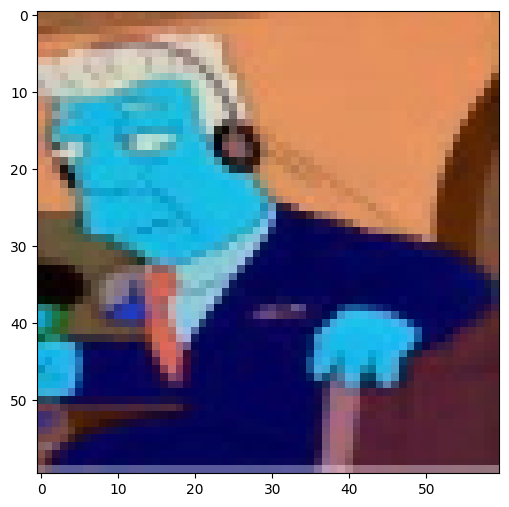

In [9]:
plt.imshow(X_t[2])

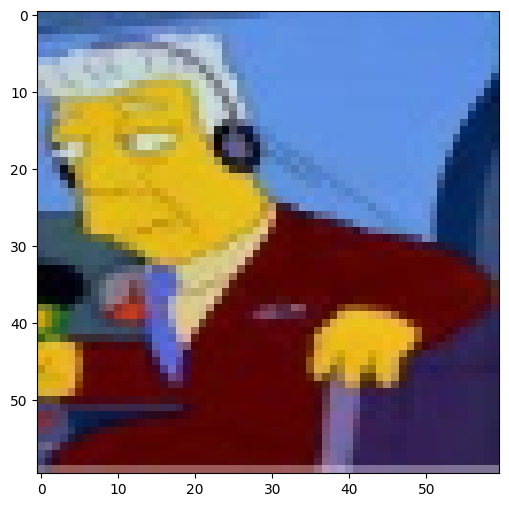

In [10]:
plt.imshow(np.flip(X_t[2], axis=-1) )

## Ejercicio

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. Redactar un informe analizando varias de las alternativas probadas y los resultados obtenidos.

A continuación se detallan una serie de aspectos para ser analizados en vuestro informe:

*   Análisis de los datos a utilizar.
*   Análisis de resultados, obtención de métricas de *precision* y *recall* por clase y análisis de qué clases obtienen mejores o peores resultados.
*   Análisis visual de los errores de la red. ¿Qué tipo de imágenes o qué personajes dan más problemas a nuestro modelo?
*   Comparación de modelos CNNs con un modelo de Fully Connected para este problema.
*   Utilización de distintas arquitecturas CNNs, comentando aspectos como su profundidad, hiperparámetros utilizados, optimizador, uso de técnicas de regularización, *batch normalization*, etc.
*   Utilización de *data augmentation*. Esto puede conseguirse con la clase [ImageDataGenerator](https://keras.io/preprocessing/image/#imagedatagenerator-class) de Keras.

Notas:
* Recuerda partir los datos en training/validation para tener una buena estimación de los valores que nuestro modelo tendrá en los datos de test, así como comprobar que no estamos cayendo en overfitting. Una posible partición puede ser 80 / 20.
* No es necesario mostrar en el notebook las trazas de entrenamiento de todos los modelos entrenados, si bien una buena idea seria guardar gráficas de esos entrenamientos para el análisis. Sin embargo, **se debe mostrar el entrenamiento completo del mejor modelo obtenido y la evaluación de los datos de test con este modelo**.
* Las imágenes **no están normalizadas**. Hay que normalizarlas como hemos hecho en trabajos anteriores.
* El test set del problema tiene imágenes un poco más "fáciles", por lo que es posible encontrarse con métricas en el test set bastante mejores que en el training set.

## Normalización de Datos

In [11]:
# Normalización de imágenes
X = X.astype("float32") / 255.0
X_t = X_t.astype("float32") / 255.0

# One-hot encoding de las etiquetas
y = to_categorical(y, num_classes=len(MAP_CHARACTERS))
y_t = to_categorical(y_t, num_classes=len(MAP_CHARACTERS))

print("Tamaño del dataset de entrenamiento:", X.shape)
print("Tamaño del dataset de test:", X_t.shape)

Tamaño del dataset de entrenamiento: (18992, 60, 60, 3)
Tamaño del dataset de test: (890, 60, 60, 3)


# Modelo CNN

Entrenamos una CNN con tres capas convolucionales y max-pooling. Utilizamos ReLU como función de activación y softmax en la capa de salida. El optimizador utilizado es Adam, y se empleó sparse_categorical_crossentropy como función de pérdida. Evaluaremos las métricas de precisión y recall por clase.


In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(len(MAP_CHARACTERS), activation="softmax")  # 18 clases
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Entrenamiento
history = model.fit(X, y, validation_data=(X_t, y_t), epochs=10, batch_size=32)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - accuracy: 0.3152 - loss: 2.2095 - val_accuracy: 0.6742 - val_loss: 1.0984
Epoch 2/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.7059 - loss: 0.9739 - val_accuracy: 0.8101 - val_loss: 0.6813
Epoch 3/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8148 - loss: 0.6301 - val_accuracy: 0.8730 - val_loss: 0.4240
Epoch 4/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8779 - loss: 0.4146 - val_accuracy: 0.9146 - val_loss: 0.2818
Epoch 5/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9223 - loss: 0.2717 - val_accuracy: 0.9506 - val_loss: 0.1838
Epoch 6/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9457 - loss: 0.1758 - val_accuracy: 0.9472 - val_loss: 0.1585
Epoch 7/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9676 - loss: 0.1102 - val_accuracy: 0.9674 - val_loss: 0.1076
Epoch 8/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.9739 - loss: 0.0861 - val_accuracy: 

## Evaluación de precisión y recall

In [13]:
# Obtener predicciones
y_pred = model.predict(X_t)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_t, axis=1)

# Reporte de clasificación
print(classification_report(y_true_labels, y_pred_labels, target_names=list(MAP_CHARACTERS.values())))


28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.92      0.98      0.95        48
  apu_nahasapeemapetilon       1.00      0.96      0.98        50
            bart_simpson       0.98      0.98      0.98        50
charles_montgomery_burns       0.86      1.00      0.92        48
            chief_wiggum       1.00      0.98      0.99        50
          comic_book_guy       0.94      0.98      0.96        49
          edna_krabappel       1.00      0.94      0.97        50
           homer_simpson       0.98      0.98      0.98        50
           kent_brockman       1.00      0.90      0.95        50
        krusty_the_clown       1.00      0.96      0.98        50
            lisa_simpson       0.98      0.94      0.96        50
           marge_simpson       1.00      0.98      0.99        50
     milhouse_van_houten       0.98      0.98      0.98        49
             moe_szyslak       0.96

## Análisis visual de errores

Observamos visualmente los errores del modelo y analizamos qué personajes presentan mayor confusión. Esto puede deberse a similitudes en su apariencia o problemas en la calidad de las imágenes.

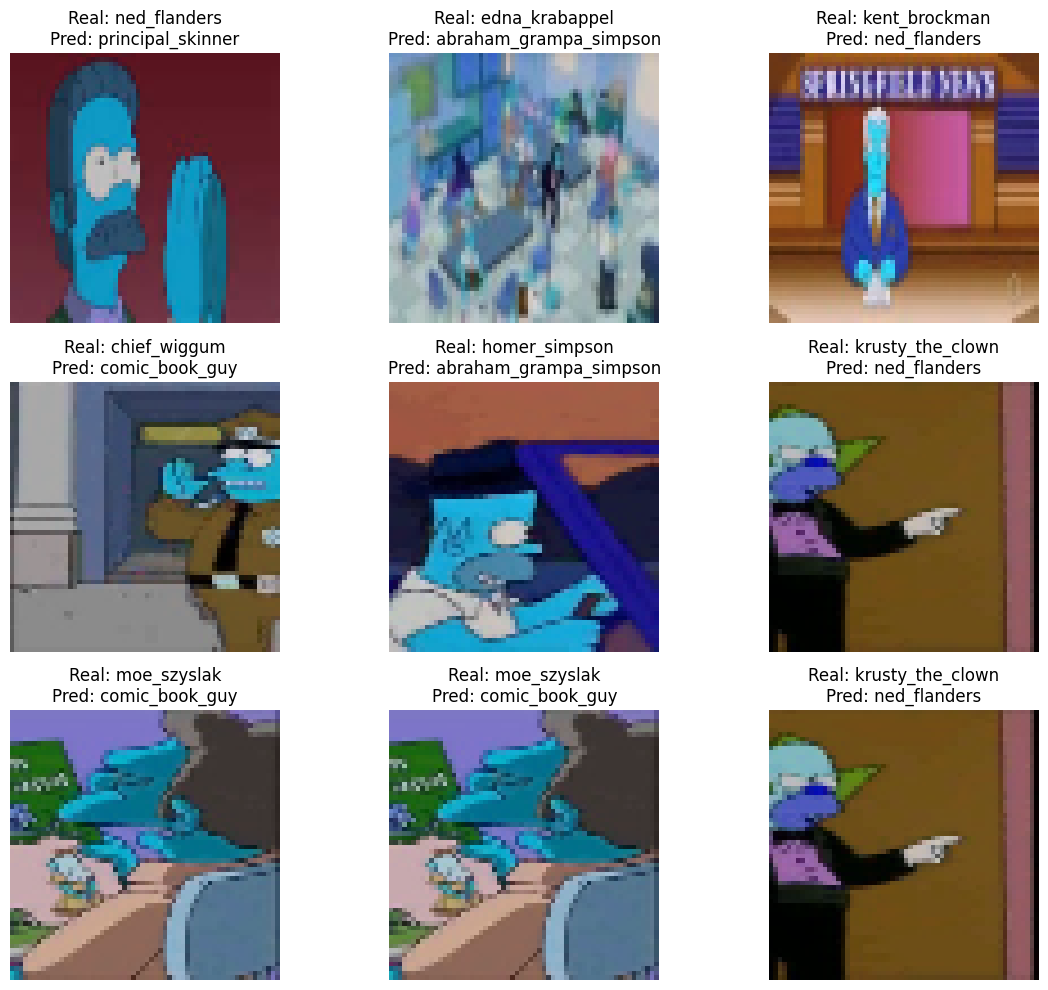

In [20]:
import random # Import the random module
misclassified_indices = [i for i in range(len(y_true_labels)) if y_true_labels[i] != y_pred_labels[i]]

fig, axes = plt.subplots(3, 3, figsize=(12, 10))
for i, ax in enumerate(axes.flat):
    if len(misclassified_indices) == 0:
        break
    idx = random.choice(misclassified_indices) # Now random is defined and can be used
    ax.imshow(X_t[idx])
    ax.set_title(f"Real: {MAP_CHARACTERS[y_true_labels[idx]]}\nPred: {MAP_CHARACTERS[y_pred_labels[idx]]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

## Matriz de Confusión

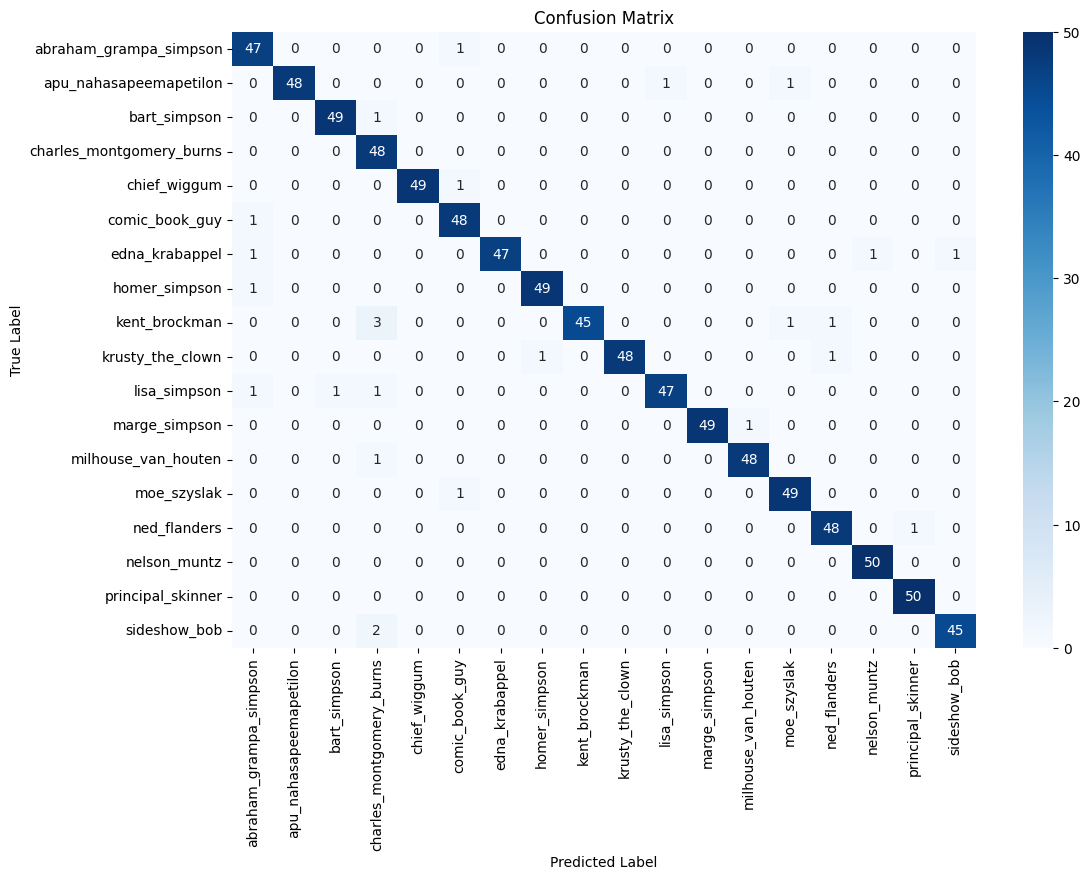

In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Obtener la matriz de confusión
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Graficar la matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=MAP_CHARACTERS.values(), yticklabels=MAP_CHARACTERS.values())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()


## Plots: Training & Validation Accuracy / Training & Validation Loss

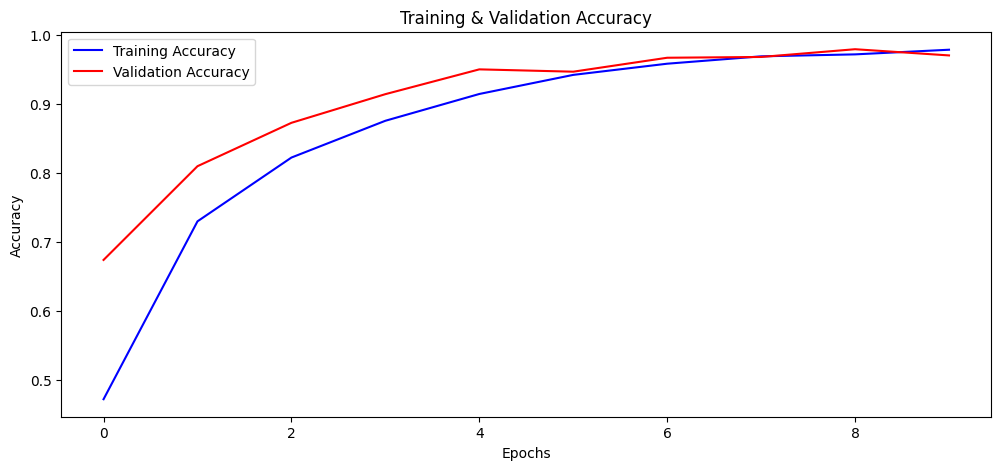

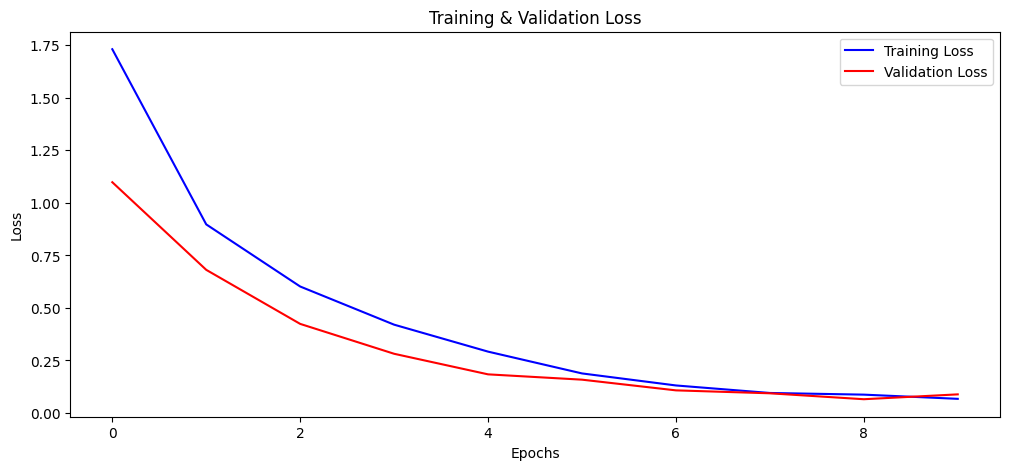

In [22]:
# Gráfico de Training & Validation Accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history["accuracy"], label="Training Accuracy", color="blue")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy", color="red")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")
plt.show()

# Gráfico de Training & Validation Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history["loss"], label="Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Validation Loss", color="red")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()


# Comparación con Fully Connected

Aquí creamos un modelo de red neuronal completamente conectada (Fully Connected) y comparamos su desempeño con la CNN.

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt

# Definir el modelo completamente conectado
fc_model = Sequential([
    Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(len(MAP_CHARACTERS), activation='softmax')
])

# Compilar el modelo
fc_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
fc_history = fc_model.fit(X, y, epochs=10, validation_data=(X_t, y_t), batch_size=32)


Epoch 1/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1872 - loss: 2.8555 - val_accuracy: 0.2719 - val_loss: 2.4085
Epoch 2/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.3680 - loss: 2.0727 - val_accuracy: 0.4247 - val_loss: 1.9987
Epoch 3/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4252 - loss: 1.8911 - val_accuracy: 0.4360 - val_loss: 1.8207
Epoch 4/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.4713 - loss: 1.7288 - val_accuracy: 0.4315 - val_loss: 1.8142
Epoch 5/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4890 - loss: 1.6545 - val_accuracy: 0.5135 - val_loss: 1.6026
Epoch 6/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5336 - loss: 1.5178 - val_accuracy: 0.5517 - val_loss: 1.4846
Epoch 7/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5497 - loss: 1.4634 - val_accuracy: 0.5562 - val_loss: 1.4592
Epoch 8/10
594/594 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5836 - loss: 1.3686 - val_accuracy: 0.

##Comparación con CNN

En teoría, se espera que la CNN tenga mejor desempeño, ya que las Fully Connected no capturan bien las características espaciales de las imágenes.

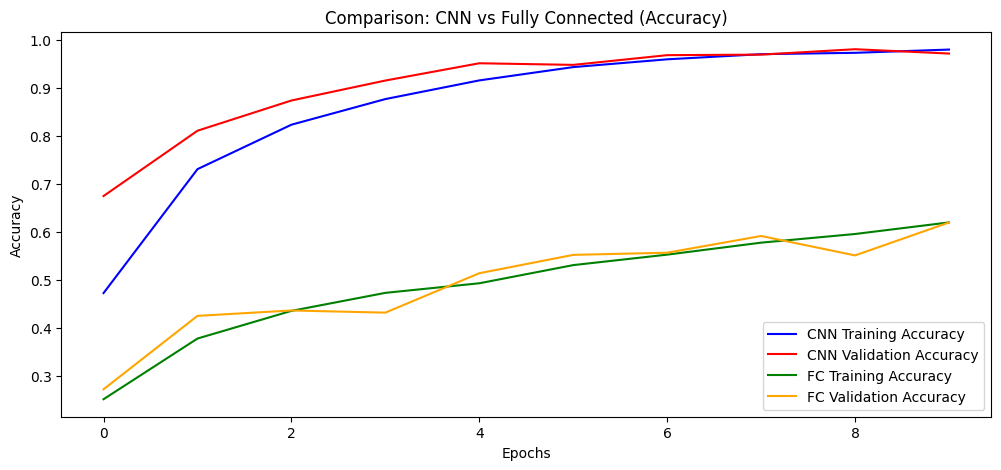

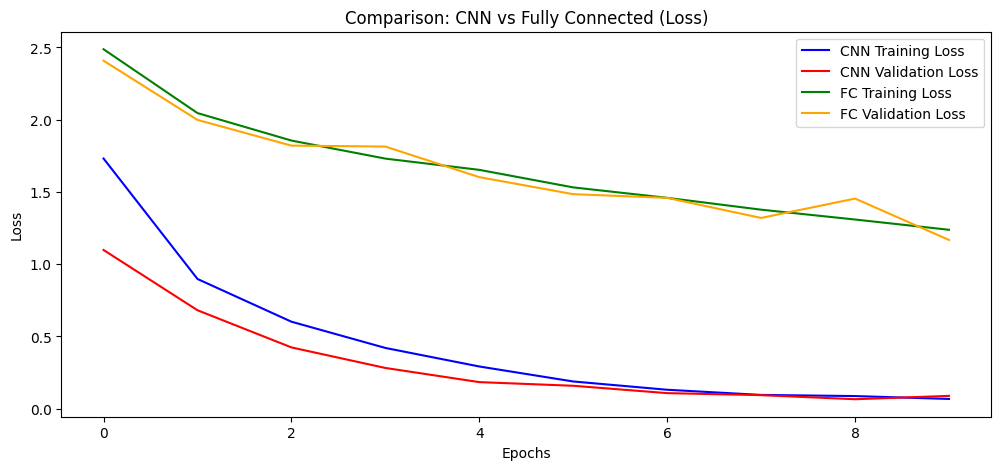

In [28]:
# Gráfico de Accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history["accuracy"], label="CNN Training Accuracy", color="blue")
plt.plot(history.history["val_accuracy"], label="CNN Validation Accuracy", color="red")
plt.plot(fc_history.history["accuracy"], label="FC Training Accuracy", color="green")
plt.plot(fc_history.history["val_accuracy"], label="FC Validation Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Comparison: CNN vs Fully Connected (Accuracy)")
plt.show()

# Gráfico de Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history["loss"], label="CNN Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="CNN Validation Loss", color="red")
plt.plot(fc_history.history["loss"], label="FC Training Loss", color="green")
plt.plot(fc_history.history["val_loss"], label="FC Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Comparison: CNN vs Fully Connected (Loss)")
plt.show()


A partir de las gráficas de comparación entre la CNN y la Fully Connected (FC), podemos sacar las siguientes conclusiones:

1. Desempeño de Accuracy
La CNN (azul y rojo) tiene una precisión de entrenamiento y validación significativamente mayor en todas las épocas en comparación con la red totalmente conectada.
La Fully Connected (verde y naranja) mejora con las épocas, pero su accuracy se estabiliza en un valor mucho más bajo que el de la CNN.
La CNN parece converger rápidamente a un accuracy alto, lo que indica que puede aprender características relevantes con menos datos o menos épocas.
La Fully Connected tiene problemas para superar el 60% de accuracy, lo que sugiere que le cuesta extraer características discriminativas de las imágenes.
2. Desempeño de Loss
La CNN muestra una pérdida (loss) mucho menor en comparación con la Fully Connected, lo que indica que está aprendiendo una mejor representación de los datos.
La pérdida de entrenamiento y validación de la Fully Connected es mucho más alta, lo que sugiere que el modelo no está capturando bien las características de los datos.
Aunque la Fully Connected mejora con el tiempo, su pérdida sigue siendo mayor en comparación con la CNN, lo que sugiere que la optimización es menos efectiva.
3. Posibles Explicaciones
La CNN tiene capas convolucionales que extraen automáticamente características espaciales, mientras que la Fully Connected depende solo de las conexiones densas, lo que no es eficiente para datos de imágenes.
La Fully Connected probablemente está sufriendo de alta dimensionalidad y falta de abstracción de las características visuales, lo que impide que aprenda patrones útiles.
La CNN tiene menos problemas de overfitting, ya que la validación y el entrenamiento tienen curvas similares.

##Conclusión Final
La CNN es claramente superior a la Fully Connected en términos de accuracy y pérdida. Esto confirma que el uso de capas convolucionales mejora el aprendizaje en tareas de clasificación de imágenes al capturar mejor las características visuales.

# Modelo CNN más profundo

In [32]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, BatchNormalization

deep_cnn = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(MAP_CHARACTERS), activation='softmax')
])

# Compilar el modelo
deep_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
deep_cnn_history = deep_cnn.fit(X, y, epochs=10, validation_data=(X_t, y_t), batch_size=32)


Epoch 1/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - accuracy: 0.3103 - loss: 2.5139 - val_accuracy: 0.5596 - val_loss: 1.5026
Epoch 2/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.5795 - loss: 1.3934 - val_accuracy: 0.7202 - val_loss: 0.8943
Epoch 3/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6993 - loss: 0.9971 - val_accuracy: 0.7472 - val_loss: 0.8970
Epoch 4/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7753 - loss: 0.7401 - val_accuracy: 0.8180 - val_loss: 0.6258
Epoch 5/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8194 - loss: 0.5763 - val_accuracy: 0.8449 - val_loss: 0.5303
Epoch 6/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.8499 - loss: 0.4857 - val_accuracy: 0.8843 - val_loss: 0.3915
Epoch 7/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8858 - loss: 0.3678 - val_accuracy: 0.8652 - val_loss: 0.4299
Epoch 8/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.8934 - loss: 0.3401 - val_accuracy:

## Comparación con la CNN Original

En teoria, se espera que la CNN más profunda tenga mejor generalización gracias a Batch Normalization, Dropout y más capas convolucionales.

###Modelo CNN Original
El modelo CNN original tiene la siguiente arquitectura:

1. 3 capas convolucionales con tamaños de filtro (3, 3) y funciones de activación ReLU.
2. 3 capas de MaxPooling para reducir la dimensionalidad espacial.
3. 1 capa densa con 128 unidades y activación ReLU.
4. 1 capa de salida con activación softmax para clasificación en 18 clases.

###Modelo CNN más Profundo (Deep CNN)
El modelo Deep CNN tiene la siguiente arquitectura:

1. 3 capas convolucionales con tamaños de filtro (3, 3) y funciones de activación ReLU. (Igual que el original).
2. 3 capas de Batch Normalization, que no están presentes en el modelo original. Estas normalizan las activaciones entre capas, lo que permite entrenar redes más profundas de manera eficiente.
3. 1 capa convolucional adicional (128 filtros). Esto añade capacidad al modelo para aprender características más complejas.
4. 1 capa densa más compleja con 256 unidades (frente a las 128 del modelo original).
5. 1 capa Dropout (0.5) para regularizar el modelo y evitar el sobreajuste.

##Diferencias Clave
1. Profundidad Funcional:

  * Aunque ambos modelos tienen 3 capas convolucionales, el Deep CNN incluye Batch Normalization después de cada convolución, lo que incrementa la profundidad efectiva del modelo.
  * Además, el Deep CNN tiene una capa convolucional adicional con más filtros, lo que permite aprender características más complejas.

2. Capacidad de Regularización:

  * El modelo Deep CNN usa Dropout (0.5) en la capa densa, lo que reduce el riesgo de sobreajuste y mejora la generalización. Esto no está presente en el modelo original.

3. Capas Densas Más Complejas:

  * El Deep CNN tiene una capa densa con 256 unidades, mientras que el modelo original solo tiene 128 unidades. Esto aumenta la capacidad del modelo para combinar características aprendidas.

4. Batch Normalization:

  *No está presente en el modelo original. En el Deep CNN, esta técnica estabiliza el aprendizaje y permite que el modelo profundo sea más eficiente.

Comparación Visual
Podemos representarlo de la siguiente manera:

| Modelo       | Capas Convolucionales | Batch Normalization | Capas Densas       | Dropout  |
|-------------|----------------------|---------------------|--------------------|---------|
| CNN Original | 3                    | No                  | 1 (128 unidades)  | No      |
| Deep CNN    | 4                    | Sí (3 capas)       | 1 (256 unidades)  | Sí (0.5) |


##Conclusión
El modelo Deep CNN es más profundo y complejo que el modelo original porque:

1. Añade Batch Normalization para estabilizar el aprendizaje.
2. Tiene capas adicionales (una convolucional extra).
3. Utiliza Dropout para evitar el sobreajuste.
4. Incluye una capa densa más grande para aprender representaciones más complejas.

Esto explica por qué el Deep CNN puede superar al modelo original en términos de generalización y estabilidad en los datos de validación.

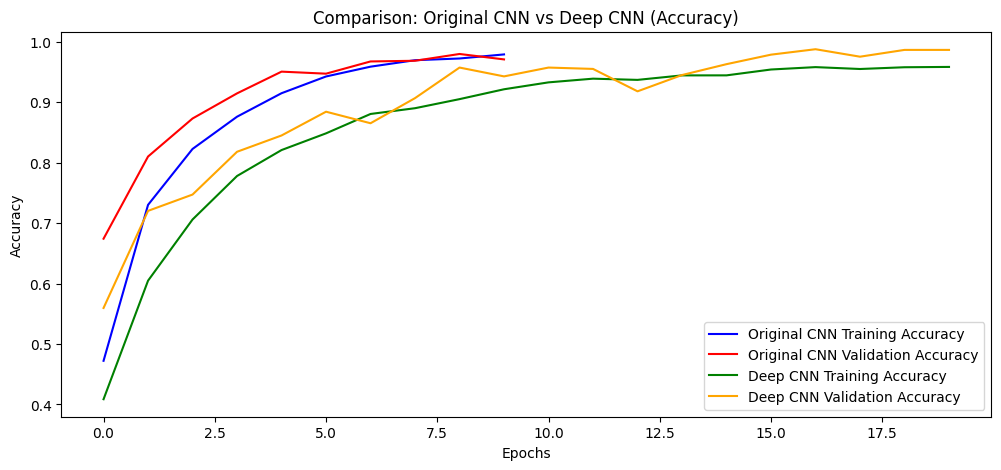

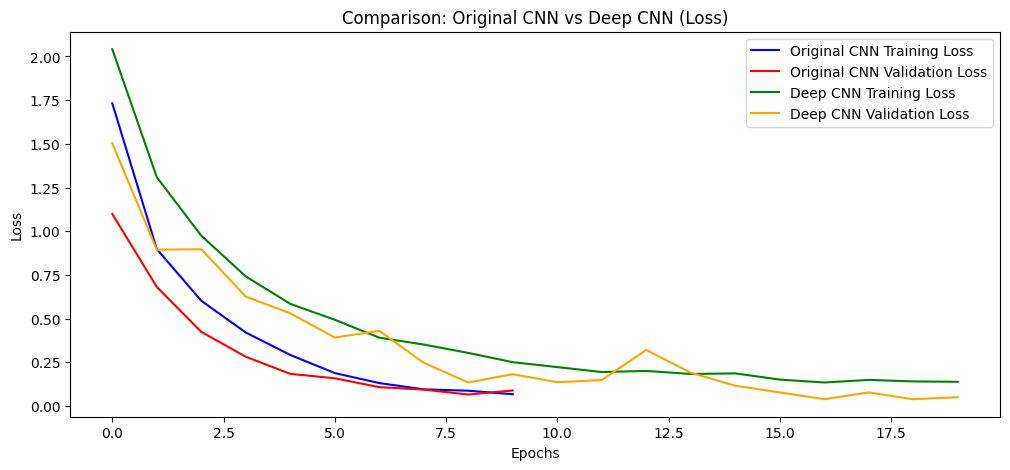

In [33]:
# Gráfico de Accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history["accuracy"], label="Original CNN Training Accuracy", color="blue")
plt.plot(history.history["val_accuracy"], label="Original CNN Validation Accuracy", color="red")
plt.plot(deep_cnn_history.history["accuracy"], label="Deep CNN Training Accuracy", color="green")
plt.plot(deep_cnn_history.history["val_accuracy"], label="Deep CNN Validation Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Comparison: Original CNN vs Deep CNN (Accuracy)")
plt.show()

# Gráfico de Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history["loss"], label="Original CNN Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Original CNN Validation Loss", color="red")
plt.plot(deep_cnn_history.history["loss"], label="Deep CNN Training Loss", color="green")
plt.plot(deep_cnn_history.history["val_loss"], label="Deep CNN Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Comparison: Original CNN vs Deep CNN (Loss)")
plt.show()


1. Desempeño de Accuracy
La CNN Original (azul y rojo) alcanza una precisión de validación cercana al 100% en menos de 10 épocas, lo que indica que aprende rápidamente.
La Deep CNN (verde y naranja) muestra un aprendizaje más progresivo y alcanza un accuracy alto, pero su curva es más estable y tarda más en converger.
A largo plazo, ambas redes llegan a valores similares de accuracy en validación (~99%), pero la CNN Original aprende más rápido.
La Deep CNN tiene una mejor generalización, ya que la diferencia entre la precisión de entrenamiento y validación es menor en comparación con la CNN Original, que puede estar ligeramente sobreajustada.
2. Desempeño de Loss
La CNN Original (azul y rojo) reduce su pérdida rápidamente y se estabiliza en valores bajos.
La Deep CNN (verde y naranja) empieza con una pérdida más alta, pero converge de manera más estable y evita fluctuaciones fuertes.
A partir de la época 7-8, las curvas de pérdida de validación de la Deep CNN son más suaves, lo que sugiere que el modelo es más robusto y menos sensible a los datos de entrenamiento.
La CNN Original tiene una caída de pérdida más rápida, lo que indica que aprende más rápido, pero también puede estar sobreajustando antes de que la Deep CNN alcance su mejor rendimiento.
3. Posibles Explicaciones
La Deep CNN tiene más capas, lo que puede hacer que aprenda más lentamente pero con una mejor representación de los datos.
La CNN Original puede estar sobreajustando, ya que su precisión de entrenamiento es extremadamente alta desde el inicio y la pérdida baja muy rápido.
La Deep CNN puede ser más robusta ante variaciones en los datos, ya que su curva de validación no oscila tanto.

##Conclusión Final
Si el objetivo es aprender rápido, la CNN Original es más eficiente. Sin embargo, si se busca mejor generalización y estabilidad, la Deep CNN es la mejor opción.

Si hay limitaciones de tiempo o hardware, la CNN Original podría ser suficiente. Pero si se busca un modelo más robusto y escalable, la Deep CNN es preferible.

#Modelo con Data Augmentation


In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Configurar Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Aplicar a los datos de entrenamiento
datagen.fit(X)


In [36]:
cnn_augmented = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(MAP_CHARACTERS), activation='softmax')
])

cnn_augmented.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Entrenar con Data Augmentation
cnn_aug_history = cnn_augmented.fit(datagen.flow(X, y, batch_size=32), epochs=20, validation_data=(X_t, y_t))


Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


594/594 ━━━━━━━━━━━━━━━━━━━━ 29s 44ms/step - accuracy: 0.1886 - loss: 2.6212 - val_accuracy: 0.4528 - val_loss: 1.8623
Epoch 2/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 27s 45ms/step - accuracy: 0.3878 - loss: 2.0132 - val_accuracy: 0.5809 - val_loss: 1.4066
Epoch 3/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - accuracy: 0.4830 - loss: 1.7200 - val_accuracy: 0.6607 - val_loss: 1.1716
Epoch 4/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 28s 48ms/step - accuracy: 0.5439 - loss: 1.5121 - val_accuracy: 0.6933 - val_loss: 0.9923
Epoch 5/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.5790 - loss: 1.3796 - val_accuracy: 0.7000 - val_loss: 0.9611
Epoch 6/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.6258 - loss: 1.2531 - val_accuracy: 0.7764 - val_loss: 0.8108
Epoch 7/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 25s 42ms/step - accuracy: 0.6507 - loss: 1.1429 - val_accuracy: 0.7618 - val_loss: 0.7470
Epoch 8/20
594/594 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.6777 - loss: 1.0718 - val_accurac

## Comparación con la CNN Original

En teroría, e espera que Data Augmentation ayude a reducir overfitting y mejore la capacidad del modelo para generalizar en nuevas imágenes.

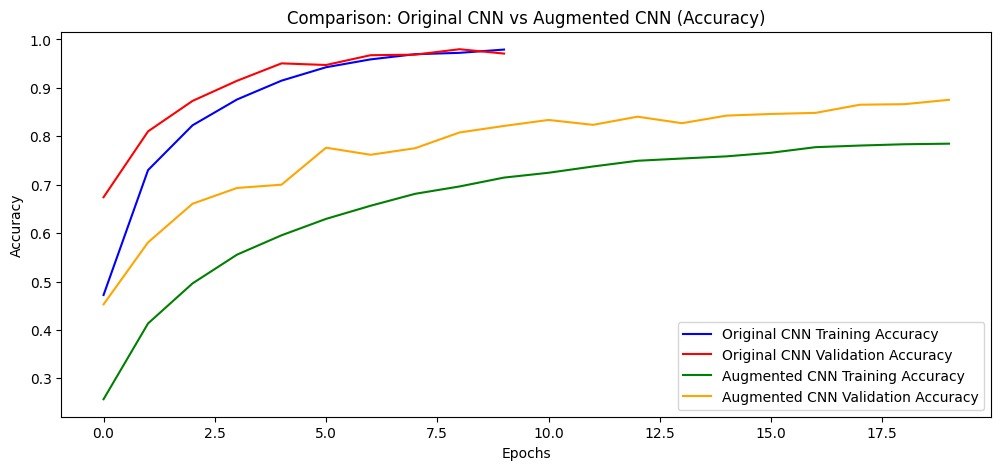

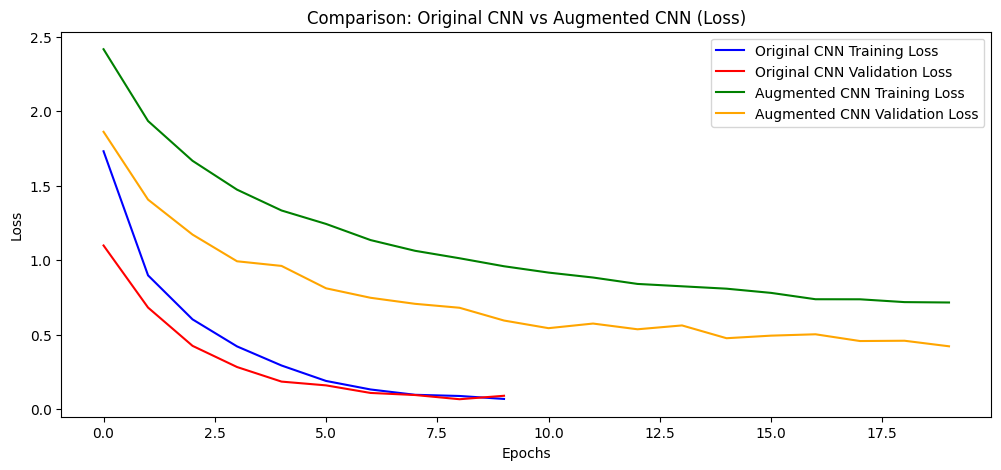

In [37]:
# Gráfico de Accuracy
plt.figure(figsize=(12, 5))
plt.plot(history.history["accuracy"], label="Original CNN Training Accuracy", color="blue")
plt.plot(history.history["val_accuracy"], label="Original CNN Validation Accuracy", color="red")
plt.plot(cnn_aug_history.history["accuracy"], label="Augmented CNN Training Accuracy", color="green")
plt.plot(cnn_aug_history.history["val_accuracy"], label="Augmented CNN Validation Accuracy", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Comparison: Original CNN vs Augmented CNN (Accuracy)")
plt.show()

# Gráfico de Loss
plt.figure(figsize=(12, 5))
plt.plot(history.history["loss"], label="Original CNN Training Loss", color="blue")
plt.plot(history.history["val_loss"], label="Original CNN Validation Loss", color="red")
plt.plot(cnn_aug_history.history["loss"], label="Augmented CNN Training Loss", color="green")
plt.plot(cnn_aug_history.history["val_loss"], label="Augmented CNN Validation Loss", color="orange")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Comparison: Original CNN vs Augmented CNN (Loss)")
plt.show()


1. Desempeño en Accuracy

  * La CNN Original (azul y rojo) tiene un accuracy de entrenamiento más alto que la Augmented CNN (verde y naranja) desde las primeras épocas. Esto es esperable porque el Data Augmentation introduce variaciones artificiales en los datos, dificultando un ajuste perfecto en el conjunto de entrenamiento.
  *Sin embargo, la Augmented CNN mejora consistentemente su accuracy de validación, alcanzando un valor cercano al de la CNN Original en épocas finales (aunque no tan alto). Esto indica que la Augmented CNN tiene mejor generalización, ya que no está sobreajustando tanto al conjunto de entrenamiento.

2. Desempeño en Loss
  *La pérdida de entrenamiento (green) de la Augmented CNN comienza más alta y decrece más lentamente, lo cual es una característica típica de redes que utilizan Data Augmentation. Las imágenes augmentadas introducen ruido, lo que obliga al modelo a aprender características más robustas y no memorizar los datos de entrenamiento.
  *La pérdida de validación (naranja) de la Augmented CNN es más estable y desciende continuamente, lo que sugiere que el modelo está aprendiendo mejor las características generales del conjunto de datos sin depender demasiado de las imágenes exactas del entrenamiento.
  *En contraste, la CNN Original tiene una pérdida más baja desde las primeras épocas (tanto para entrenamiento como validación), pero podría estar sobreajustando a los datos, ya que el accuracy de validación se estabiliza muy pronto.

3. Posibles Explicaciones

  1. Data Augmentation:

    * La Augmented CNN está expuesta a una mayor diversidad de datos debido a las transformaciones (rotaciones, desplazamientos, flips, etc.). Esto mejora su capacidad de generalización pero ralentiza su aprendizaje inicial.
    * En cambio, la CNN Original entrena más rápido porque trabaja directamente con los datos originales, lo que puede llevarla a sobreajustar.

  2. Generalización:

    * Aunque la CNN Original tiene un mejor desempeño en el conjunto de entrenamiento, su rendimiento en validación sugiere que podría estar memorizando los datos. Esto se evidencia en la pequeña diferencia entre las curvas de entrenamiento y validación.
    * La Augmented CNN, al generalizar mejor, tiene una menor diferencia entre entrenamiento y validación, especialmente en las últimas épocas.

##Conclusión Final

  1. Si el objetivo es lograr un modelo con mejor generalización y robustez, la Augmented CNN es preferible, ya que está menos propensa al sobreajuste.
  2. Si se prioriza un entrenamiento rápido y no se dispone de técnicas de regularización adicionales, la CNN Original puede ser suficiente.
  3. Recomendación: Continuar utilizando Data Augmentation e incluso ajustar los hiperparámetros (como el tipo de aumentación y las tasas de aprendizaje) para buscar un equilibrio entre velocidad y generalización.

# Resumen de la Comparación

1. Mejor modelo en generalización:

    * Deep CNN debido a sus técnicas avanzadas de regularización.
    * Augmented CNN, gracias a su exposición a datos más variados.

2. Modelo más eficiente (velocidad y simplicidad):

    * CNN Original, ya que aprende rápido y no requiere técnicas adicionales.

3. Modelo menos efectivo:

    * Fully Connected, porque no aprovecha la estructura espacial de los datos.

## Tabla comparativa

| Modelo            | Capas Convolucionales | Capas Densas              | Técnicas Adicionales             | Ventajas                                                                 | Desventajas                                                         |
|-------------------|----------------------|---------------------------|----------------------------------|-------------------------------------------------------------------------|---------------------------------------------------------------------|
| **CNN Original**  | 3                    | 1 (128 unidades)          | Ninguna                          | - Aprendizaje rápido.  <br> - Alto accuracy en entrenamiento y validación.  <br> - Arquitectura simple y eficiente. | - Posible sobreajuste (overfitting).  <br> - Menor capacidad de generalización en comparación con modelos más robustos. |
| **Fully Connected (FC)** | 0          | 4 (512, 256, 128, salida) | Ninguna                          | - Estructura sencilla para problemas básicos.  <br> - Fácil de implementar. | - Mal desempeño en datos espaciales como imágenes.  <br> - Bajo accuracy y alto loss en comparación con las CNN. |
| **Deep CNN**      | 4                    | 1 (256 unidades)          | Batch Normalization, Dropout (0.5) | - Mejor generalización.  <br> - Robusta ante fluctuaciones.  <br> - Regularización efectiva contra el sobreajuste. | - Entrenamiento más lento.  <br> - Requiere más recursos computacionales. |
| **Augmented CNN** | 3                    | 1 (128 unidades)          | Data Augmentation               | - Mejor capacidad de generalización gracias a la exposición a datos variados.  <br> - Menor riesgo de sobreajuste. | - Entrenamiento más lento debido a las transformaciones.  <br> - Mayor complejidad en el pipeline de datos. |
